In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define the paths to the datasets
normal_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/NORMAL ENC 3.5'
benign_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/BENIGN ENC 3.5'
malignant_dir = '/content/drive/MyDrive/AYYO DEVARE/Result/MALIGNANT ENC 3.5'

# Classes and directories
classes = ['normal', 'benign', 'malignant']
input_dirs = [normal_dir, benign_dir, malignant_dir]

# Function to load images from a directory and return as numpy arrays
def load_images_from_directory():
    images = []
    labels = []
    for label, class_dir in enumerate(input_dirs):
        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)

# Load images and labels from directories
all_images, all_labels = load_images_from_directory()

# Normalize the images
all_images = all_images / 255.0

# Convert labels to categorical
all_labels = to_categorical(all_labels, num_classes=len(classes))

# Split the dataset: 70% train, 20% test, 10% validation
train_images, temp_images, train_labels, temp_labels = train_test_split(
    all_images, all_labels, test_size=0.3, random_state=42, stratify=all_labels)

val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=2/3, random_state=42, stratify=temp_labels)

In [3]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.9/190.9 MB 5.4 MB/s eta 0:00:00


57/57 [==============================] - 48s 835ms/step
SVM + RandomForest Ensemble Combined Test accuracy: 0.8896
SVM + RandomForest Ensemble Combined Test loss: 0.3127
SVM + RandomForest Ensemble Classification Report:
              precision    recall  f1-score   support

      Normal       0.84      0.86      0.85       900
      Benign       0.85      0.83      0.84       900
   Malignant       0.99      0.98      0.98       900

    accuracy                           0.89      2700
   macro avg       0.89      0.89      0.89      2700
weighted avg       0.89      0.89      0.89      2700



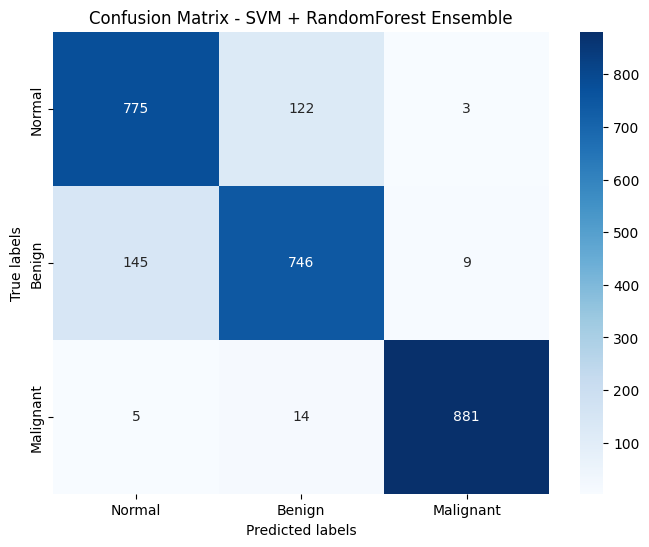

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


RandomForest + XGBoost Ensemble Combined Test accuracy: 0.8952
RandomForest + XGBoost Ensemble Combined Test loss: 0.2940
RandomForest + XGBoost Ensemble Classification Report:
              precision    recall  f1-score   support

      Normal       0.85      0.87      0.86       900
      Benign       0.85      0.84      0.85       900
   Malignant       0.98      0.98      0.98       900

    accuracy                           0.90      2700
   macro avg       0.90      0.90      0.90      2700
weighted avg       0.90      0.90      0.90      2700



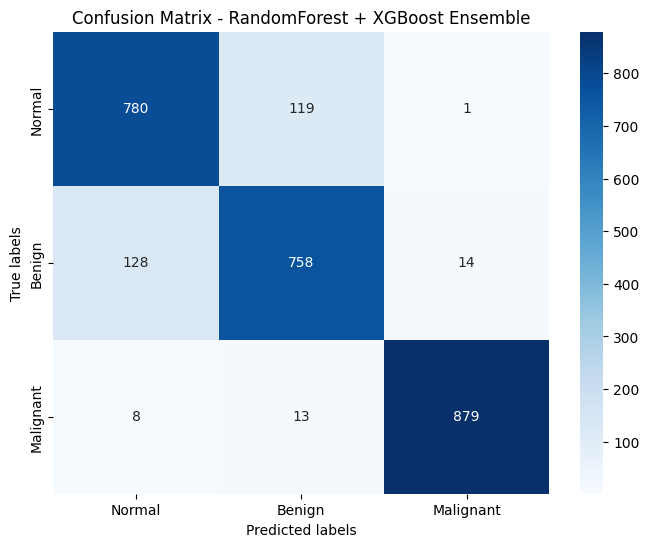

In [4]:
import numpy as np
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns

# Load DenseNet201 without top classification layers
densenet201_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add GlobalAveragePooling layer
densenet201_output = GlobalAveragePooling2D()(densenet201_model.output)

# Create model for feature extraction
densenet201_extractor = Model(inputs=densenet201_model.input, outputs=densenet201_output)

# Assuming train_images, train_labels, val_images, val_labels, test_images, test_labels are defined elsewhere

# Extract features from DenseNet201
train_features_densenet201 = densenet201_extractor.predict(train_images)
val_features_densenet201 = densenet201_extractor.predict(val_images)
test_features_densenet201 = densenet201_extractor.predict(test_images)

# Combine features
train_features = train_features_densenet201
val_features = val_features_densenet201
test_features = test_features_densenet201

# Combine validation and test features for classification
combined_features = np.concatenate((val_features, test_features), axis=0)
combined_labels = np.concatenate((np.argmax(val_labels, axis=1), np.argmax(test_labels, axis=1)), axis=0)

# Train classifiers for ensembles
rf = RandomForestClassifier(n_estimators=100)
svm = SVC(probability=True)
xgb = XGBClassifier()

# Fit RandomForest and SVM ensemble
rf_svm_ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('svm', svm)
], voting='soft')

# Fit RandomForest and XGBoost ensemble
rf_xgb_ensemble = VotingClassifier(estimators=[
    ('rf', rf),
    ('xgb', xgb)
], voting='soft')

# Fit the classifiers
rf.fit(train_features, np.argmax(train_labels, axis=1))
svm.fit(train_features, np.argmax(train_labels, axis=1))
xgb.fit(train_features, np.argmax(train_labels, axis=1))

# Fit the ensembles
rf_svm_ensemble.fit(train_features, np.argmax(train_labels, axis=1))
rf_xgb_ensemble.fit(train_features, np.argmax(train_labels, axis=1))

# Evaluate SVM + RandomForest ensemble
preds_rf_svm = rf_svm_ensemble.predict(combined_features)
prob_preds_rf_svm = rf_svm_ensemble.predict_proba(combined_features)
accuracy_rf_svm = accuracy_score(combined_labels, preds_rf_svm)
loss_rf_svm = log_loss(combined_labels, prob_preds_rf_svm)
print(f'SVM + RandomForest Ensemble Combined Test accuracy: {accuracy_rf_svm:.4f}')
print(f'SVM + RandomForest Ensemble Combined Test loss: {loss_rf_svm:.4f}')

conf_matrix_rf_svm = confusion_matrix(combined_labels, preds_rf_svm)
print(f'SVM + RandomForest Ensemble Classification Report:')
print(classification_report(combined_labels, preds_rf_svm, target_names=['Normal', 'Benign', 'Malignant']))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_svm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Benign', 'Malignant'], yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - SVM + RandomForest Ensemble')
plt.show()

# Evaluate RandomForest + XGBoost ensemble
preds_rf_xgb = rf_xgb_ensemble.predict(combined_features)
prob_preds_rf_xgb = rf_xgb_ensemble.predict_proba(combined_features)
accuracy_rf_xgb = accuracy_score(combined_labels, preds_rf_xgb)
loss_rf_xgb = log_loss(combined_labels, prob_preds_rf_xgb)
print(f'RandomForest + XGBoost Ensemble Combined Test accuracy: {accuracy_rf_xgb:.4f}')
print(f'RandomForest + XGBoost Ensemble Combined Test loss: {loss_rf_xgb:.4f}')

conf_matrix_rf_xgb = confusion_matrix(combined_labels, preds_rf_xgb)
print(f'RandomForest + XGBoost Ensemble Classification Report:')
print(classification_report(combined_labels, preds_rf_xgb, target_names=['Normal', 'Benign', 'Malignant']))
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf_xgb, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Benign', 'Malignant'], yticklabels=['Normal', 'Benign', 'Malignant'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix - RandomForest + XGBoost Ensemble')
plt.show()
